# EMR Twitter Data Sentiment Visualisation 

## This notebook walks through:

  - Loading Twitter Data, using the Tweepy library
  - Cleaning the Tweets
  - Visualising and Removing Stopwords 
  - Applying sentiment analysis to the data
  - Visualising the sentiment

# Importing libraries

In [1]:
import tweepy
import configparser
import pandas as pd
import regex as re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregormilligan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing the api keys to access twitter

In [ ]:
# read configs
config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

# authentication
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# A function to get datat from twitter

In [2]:
def getTweets(keywords):
    limit = 300
    tweets = tweepy.Cursor(api.search_tweets, q=keywords, count=100, tweet_mode="extended")
    columns = ['Tweet']
    data = []
    for tweet in tweets.items():
            data.append(tweet.full_text)
    tweetDF = pd.DataFrame(data,columns=columns)
    return tweetDF

In [3]:
df = getTweets('@EastMidRailway')
df

,Tweet
0,@EastMidRailway strange how you allow bike's t...
1,@alisonmbrady72 @EastMidRailway Thank you for ...
2,@EastMidRailway Awaiting your response please
3,It’s been over a month since I rode on an @Eas...
4,@vixisabel @EastMidRailway Was lovely to meet ...
...,...
565,@EastMidRailway During the consultations we wa...
566,@EastMidRailway Is it worth me trying to get t...
567,"#FrogWombleCup Round 5, Game 110\n@IslandLineU..."
568,@EastMidRailway where have all the advance tic...


# Cleaning the data

In [12]:
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #removes @mentions
    text = re.sub(r'#','',text)#removes #
    text = re.sub(r'RT[\s]','', text)#removes RTs
    text = re.sub('https?:\/\/\S+','',text)#removes hyperlinks  
    text = re.sub(r'[^\w\s]', '', text)
    df.drop_duplicates()
    return text
df['Tweet'] = df['Tweet'].apply(cleanTxt)
#show clean text
df

,Tweet
0,Great thanm you Do I place the order first an...
1,oh fabulous I thought that ended in January T...
2,1136 Nottingham to Skegness Every seat on the...
3,Thank you is there likely to be a charge
4,Why have you taken every folding table off of...
...,...
602,Fantastic Sam
603,Another truly special moment from yesterday T...
604,Amazing Well done Sam at
605,Amazing Well done Sam at


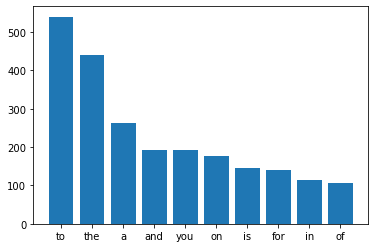

In [36]:
corpus=[]
words= df['Tweet'].str.split()
words=words.values.tolist()
corpus=[word for i in words for word in i]
%matplotlib inline 
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
plot_top_stopwords_barchart(df['Tweet'])

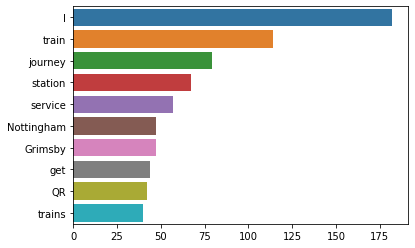

In [14]:
def commonWordPlot(text):
    
    counter=Counter(text)
    most=counter.most_common()

    x, y= [], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
        
    sns.barplot(x=y,y=x)
commonWordPlot(corpus)

In [15]:
#Creating a function to get the subjectivity (How opinionated the text is)
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
#polarity of the tweets positive negative or neutral 
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
df['Subjectivity'] = df['Tweet'].apply(getSubjectivity)
df['Polarity'] = df['Tweet'].apply(getPolarity)
df

,Tweet,Subjectivity,Polarity
0,Great thanm you Do I place the order first an...,0.541667,0.525000
1,oh fabulous I thought that ended in January T...,0.733333,0.033333
2,1136 Nottingham to Skegness Every seat on the...,0.025000,-0.100000
3,Thank you is there likely to be a charge,1.000000,0.000000
4,Why have you taken every folding table off of...,0.000000,0.000000
...,...,...,...
602,Fantastic Sam,0.900000,0.400000
603,Another truly special moment from yesterday T...,0.385714,0.278571
604,Amazing Well done Sam at,0.900000,0.600000
605,Amazing Well done Sam at,0.900000,0.600000


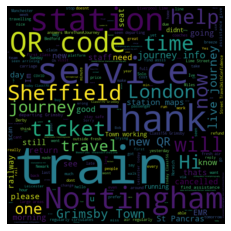

In [16]:
#visualise tweets in a wordcloud
all_words = ' '.join([tweets for tweets in df['Tweet']])
wordcloud = WordCloud(width = 500, height = 500, random_state=21, max_font_size= 119, stopwords=STOPWORDS).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['Analysis'] = df['Polarity'].apply(getAnalysis)
df

,Tweet,Subjectivity,Polarity,Analysis
0,Great thanm you Do I place the order first an...,0.541667,0.525000,Positive
1,oh fabulous I thought that ended in January T...,0.733333,0.033333,Positive
2,1136 Nottingham to Skegness Every seat on the...,0.025000,-0.100000,Negative
3,Thank you is there likely to be a charge,1.000000,0.000000,Neutral
4,Why have you taken every folding table off of...,0.000000,0.000000,Neutral
...,...,...,...,...
602,Fantastic Sam,0.900000,0.400000,Positive
603,Another truly special moment from yesterday T...,0.385714,0.278571,Positive
604,Amazing Well done Sam at,0.900000,0.600000,Positive
605,Amazing Well done Sam at,0.900000,0.600000,Positive


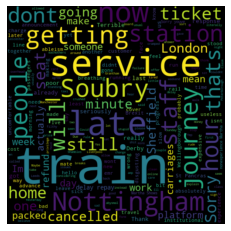

In [49]:
sortedDF = df.sort_values(by=['Polarity'])
sortedDF.to_excel('train_exampleReal.xlsx')
#negative sentiment
all_words = ' '.join([tweets for tweets in sortedDF['Tweet'][0:100]])
wordcloud = WordCloud(width = 500, height = 500, random_state=21, max_font_size= 119, stopwords=STOPWORDS).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color="violet")
    
plt.title("Railway Sentiment Analysis")
plt.xlabel("Polarity")
plt.ylabel("Subjectivty")
plt.show()

/Users/gregormilligan/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: If using all scalar values, you must pass an index

<AxesSubplot:xlabel='Polarity', ylabel='Subjectivity'>

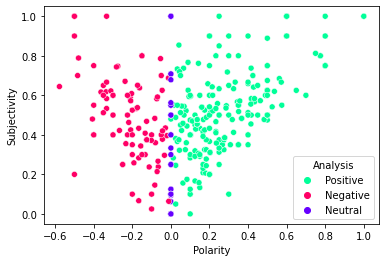

In [39]:
colors = ["#00ff99", "#ff0066",'#6600ff']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

sns.scatterplot(data = df, x ="Polarity", y = df['Subjectivity'], hue=df['Analysis'])